In [56]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import regularizers


import tensorflow as tf
from tensorflow.keras import layers
import chess
import numpy as np


In [57]:
def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    turn_part = parts[1]
    castling_part = parts[2]

    # Convert the board position to a binary matrix
    board = chess.Board(fen)
    binary_board = np.zeros((8, 8, 18), dtype=np.float32)
    pieces = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5,
              'P': 6, 'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11}
    
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            binary_board[i // 8, i % 8, pieces[str(piece)]] = 1.0

    # Add the turn to the binary matrix
    if turn_part == 'w':
        binary_board[..., 12] = 1.0
    else:
        binary_board[..., 13] = 1.0

    # Add the castling rights to the binary matrix
    if 'K' in castling_part:
        binary_board[..., 14] = 1.0
    if 'Q' in castling_part:
        binary_board[..., 15] = 1.0
    if 'k' in castling_part:
        binary_board[..., 16] = 1.0
    if 'q' in castling_part:
        binary_board[..., 17] = 1.0

    return binary_board


In [58]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 18), 
                  kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Dropout layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Dropout layer
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Dropout layer
    layers.Dense(1)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


In [59]:
with open(r'fen_ratingsomate2.txt', 'r') as f:
    lines = f.readlines()

fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [int(line.split()[-1]) for line in lines]


boards = np.array([fen_to_board(fen) for fen in fens])
ratings = np.array(ratings)

In [60]:
train_size = int(len(boards) * 0.7)
val_size = int(len(boards) * 0.15)

x_train, y_train = boards[:train_size], ratings[:train_size]
x_val, y_val = boards[train_size:train_size+val_size], ratings[train_size:train_size+val_size]
x_test, y_test = boards[train_size+val_size:], ratings[train_size+val_size:]


In [61]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 32)          │      5,216 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)          │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_8 (Flatten)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 64)                │     16,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_5 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 40,225 (157.13 KB)

 Trainable params: 40,225 (157.13 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=50)

Epoch 1/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.0085 - loss: 5231876.0000 - val_accuracy: 0.0181 - val_loss: 3330383.0000
Epoch 2/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.0143 - loss: 3485158.0000 - val_accuracy: 0.0138 - val_loss: 3009248.0000
Epoch 3/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.0141 - loss: 3205675.0000 - val_accuracy: 0.0147 - val_loss: 2915315.5000
Epoch 4/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.0150 - loss: 3019846.7500 - val_accuracy: 0.0122 - val_loss: 2839114.2500
Epoch 5/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.0142 - loss: 3027476.7500 - val_accuracy: 0.0156 - val_loss: 2753953.0000
Epoch 6/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.0149 - loss: 2933539.2500 - val_accuracy: 0.0183 - val_loss: 2775964.7500
Epoch 7/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.0148 - loss: 2944873.0000 - val_accuracy: 0.0130 - val_loss: 2692868.2500

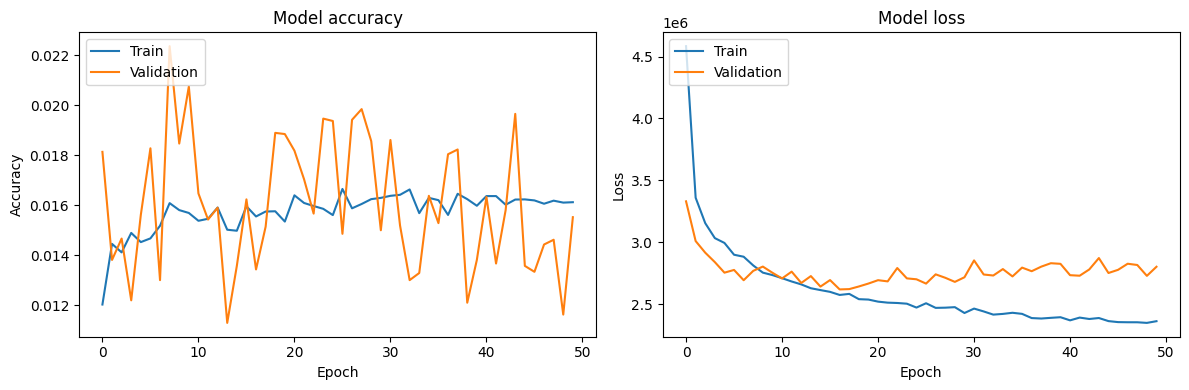

In [63]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [64]:
model.save('TrainedModel.h5')

In [65]:
# Predict the ratings for the test data
y_pred = model.predict(x_test)

# Print the predicted and true ratings for the test data
for i in range(len(x_test)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")


658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Predicted rating: [8.486747], True rating: 5
Predicted rating: [2.6969337], True rating: 88
Predicted rating: [3.3756964], True rating: 74
Predicted rating: [2.9696093], True rating: 57
Predicted rating: [6.496725], True rating: 62
Predicted rating: [9.581469], True rating: 536
Predicted rating: [27.671188], True rating: 228
Predicted rating: [57.862434], True rating: 431
Predicted rating: [24.0278], True rating: -482
Predicted rating: [1.2715418], True rating: -478
Predicted rating: [19.068314], True rating: -546
Predicted rating: [55.943336], True rating: -530
Predicted rating: [36.577644], True rating: -537
Predicted rating: [24.089272], True rating: -542
Predicted rating: [-8.050201], True rating: -607
Predicted rating: [-40.99534], True rating: -578
Predicted rating: [-47.273647], True rating: -582
Predicted rating: [-51.91338], True rating: -583
Predicted rating: [11.626447], True rating: 27
Predicted rating: [12.338364], True rating: 34
P

In [66]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
